In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

In [3]:
from random_features import RFF

In [4]:
sampler = lambda shape: multivariate_normal(mean=[0]*3, cov=np.eye(3)).rvs(size=np.product(shape))

In [5]:
n_features = 20
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=3)

In [6]:
pts = np.arange(0, 1, 0.1).reshape(-1, 1).repeat(3, axis=1)

In [7]:
features = rff.get_random_features(pts)

In [8]:
assert features.shape == (len(pts), n_features)

# Main Part

In [9]:
from data_utils import Landscape

In [37]:
landscape = Landscape(num_landmarks=20)
landscape.initialize()

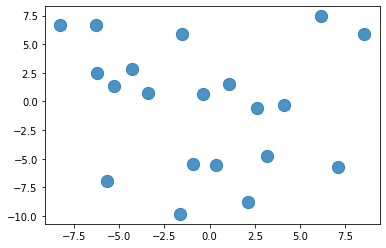

In [38]:
plt.scatter(landscape.landmarks[:, 0], landscape.landmarks[:, 1], s=150, alpha=0.8)

In [75]:
from data_utils import Odometry

N_pts = 100

odometry = Odometry(landscape, observation_dim=3, max_time=10)
odometry.generate(N_pts)

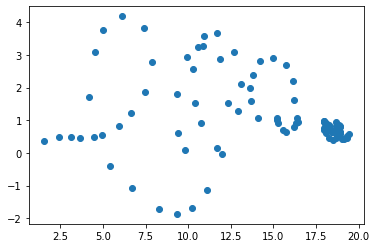

In [76]:
plt.scatter(np.array(odometry.states)[:, 0], np.array(odometry.states)[:, 1])

In [77]:
from model import Model
from observation import RangeModel 
from data_utils import get_prediction


sampler = lambda shape: multivariate_normal(mean=[0], cov=(1./3**2)*np.eye(1)).rvs(size=np.product(shape))

n_features = 100
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=1)

#initial_values = np.zeros((n_features*3)+2*len(landscape.landmarks))

range_model = RangeModel(odometry.Q[0,0])

def prior_mean(t, state_estimates):
    i = odometry.times.index(t)
    state = get_prediction(state_estimates[i], odometry.motions[i])
    return state

initial_values = np.concatenate([np.zeros(n_features*3), landscape.landmarks.reshape(-1)])
b_means = np.concatenate([np.zeros(n_features*3), landscape.landmarks.reshape(-1)])


model = Model(rff=rff, 
              initial_values=initial_values,
              initial_state=odometry.states[0],
              times=odometry.times,
              measurements=np.stack(odometry.observations, 0)[:, 0, [0, 2]],
              measurement_covs=[odometry.Q[:1, :1]]*N_pts,
              motions=odometry.motions,
              b_means=b_means,
              b_covs=[0.01*np.eye(n_features)]*3,
              land_means=landscape.landmarks,
              land_cov=[0.01*np.eye(2)]*len(landscape.landmarks),
              observation_model=range_model,
              prior_mean=prior_mean,
              dampening_factor=0.01,
            )

In [78]:
model.run_slam(100)

0.08237965930133508
0.003685217248541562
0.0028951216759898714
0.0027100271685977563
0.0024860551346073552
0.002284835232280167
0.001920061508531093
0.002025470736470532
0.001768383572247454
0.0016333082362587122
0.0015446138838494587
0.0015221043974307906
0.0014367138937974855
0.0015528288208202922
0.0014790553012643311
0.001428996520865542
0.0010225440603659408
0.0009494661382148776


In [79]:
np.array(odometry.states[1:11])#, np.array(odometry.states[:10])+np.array(odometry.motions[:10])

array([[ 2.42988769,  0.48140126,  0.133021  ],
       [ 3.10837635,  0.49725949,  0.0955616 ],
       [ 3.66266367,  0.46091103,  0.08307618],
       [ 4.96386267,  0.53643048,  0.24751046],
       [ 5.9262137 ,  0.82391721,  0.54506929],
       [ 6.66819192,  1.21840638,  0.6673364 ],
       [ 7.44577931,  1.86863024,  1.03537358],
       [ 7.85246074,  2.78586035,  1.94659701],
       [ 7.42238813,  3.81839123,  2.68571153],
       [ 6.11399781,  4.18198363, -2.7992202 ]])

In [80]:
model.prior_means[:10]

[array([2.5051439 , 0.48198039, 0.11934431]),
 array([3.73662663, 0.46662809, 0.12289053]),
 array([4.79309927, 0.41065315, 0.14206881]),
 array([5.89313222, 0.47333547, 0.4740361 ]),
 array([6.95017627, 0.86724507, 0.73252589]),
 array([7.80714175, 1.37550382, 0.94551983]),
 array([8.58377105, 2.15716542, 1.39665711]),
 array([8.89254975, 3.11164323, 2.06153411]),
 array([8.4646815 , 4.03679327, 2.75370973]),
 array([ 7.45423788,  4.23935603, -2.82350953])]

In [81]:
model.states[:10]

array([[ 2.66657397,  0.42659133,  0.1197512 ],
       [ 3.89317606,  0.4084378 ,  0.12329317],
       [ 4.95258885,  0.35471183,  0.14247604],
       [ 6.05546857,  0.43109643,  0.47441735],
       [ 7.0971595 ,  0.8106117 ,  0.73291522],
       [ 7.94825728,  1.32381878,  0.94587678],
       [ 8.74460024,  2.07262894,  1.39702588],
       [ 9.03627199,  3.04659378,  2.06190745],
       [ 8.62533648,  3.99442999,  2.75409001],
       [ 7.61160669,  4.20465778, -2.82319567]])

In [48]:
model.b[300:].reshape(-1, 2), landscape.landmarks

(array([[ 0.36988602, -5.58698035],
        [ 6.12739419,  7.42731068],
        [ 8.54930322,  5.86265283],
        [-0.36877493,  0.62625552],
        [-6.19470738,  2.53465497],
        [-1.53306583,  5.85483251],
        [-5.73854841, -6.95341559],
        [-1.60916323, -9.81795274],
        [ 2.59041729, -0.57816988],
        [-3.37311895,  0.75319768],
        [-8.28710965,  6.55864772],
        [-6.27794594,  6.69412922],
        [ 2.19021075, -8.77393975],
        [ 7.20496165, -5.64705138],
        [-0.93579949, -5.4551135 ],
        [ 1.05910516,  1.52618639],
        [-5.30083557,  1.38128727],
        [ 4.12729496, -0.35618048],
        [-4.27993394,  2.8707865 ],
        [ 3.15630732, -4.75903717]]),
 array([[ 0.36495967, -5.59392936],
        [ 6.13608863,  7.43608064],
        [ 8.55858033,  5.87190527],
        [-0.36884816,  0.62618228],
        [-6.23825207,  2.50083814],
        [-1.53596109,  5.92160411],
        [-5.70009809, -6.98794528],
        [-1.62903372, -9.8